# BEE 4750 Final Project Code

**Name**: 

**ID**: 

> **Due Date**
>


## Setup


=== DNA-ONLY SCENARIO ===
Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 27 rows; 15 cols; 52 nonzeros; 1 integer variables (1 binary)
Coefficient ranges:
  Matrix  [1e+00, 4e+01]
  Cost    [3e+05, 9e+05]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 4e+01]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-27); columns 0(-15); nonzeros 0(-52) - Reduced to empty
Presolve: Optimal

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Pro

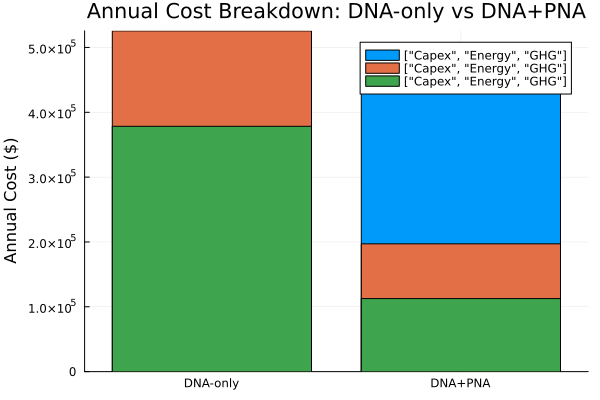

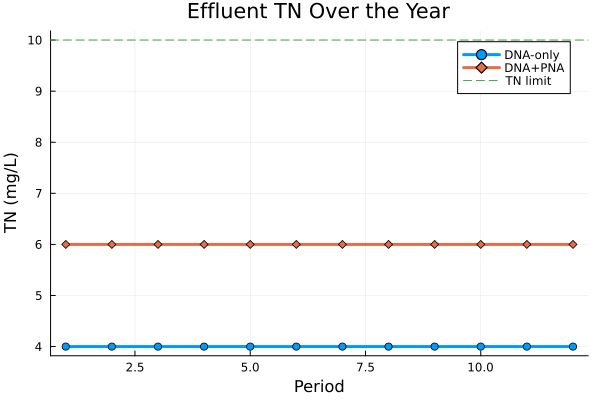

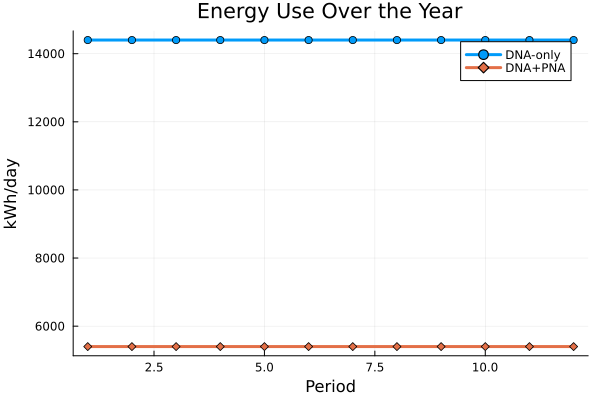

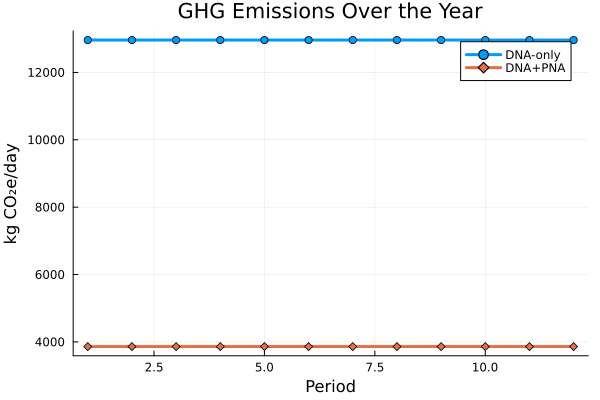

In [ ]:
using JuMP
using HiGHS
using Plots

# 1. DATA / PARAMETERS

T = 1:12                          # 12 periods (e.g. months)
nT = length(T)

# Flow and load
Q   = 100_000.0                   # m3/d 
Cin = 40.0                        # mg N/L
Lin = Q * Cin / 1000.0            # kg N/d

# Days in each period (approx monthly)
days = fill(365.0 / 12.0, nT)

# Performance & energy parameters (PLACEHOLDERS)

# Fraction of N removed in each period by each system
# You can later replace these with temperature-based values per month
eta_DNA = fill(0.90, nT)          # DNA removal efficiency
eta_PNA = fill(0.85, nT)          # PNA removal efficiency

# kWh per kg N removed (or treated) for each technology
e_DNA   = fill(4.0,  nT)          # DNA aeration
e_PNA   = fill(1.0,  nT)          # PNA aeration
e_heat  = fill(0.5,  nT)          # heating energy per kg N in PNA (example)

# Effluent TN limit
TN_target = 10.0                  # mg/L

# Economic & GHG parameters
c_elec       = 0.10               # $/kWh
EF_elec      = 0.4                # kg CO2e/kWh (grid)
EF_DNA       = fill(2.0, nT)      # kg CO2e/kgN removed in DNA (N2O etc.) placeholder will become: eta_DNA = [eta_DNA_ref * theta_DNA^(T[t] - Tref) for t in T]
EF_PNA       = fill(0.5, nT)      # kg CO2e/kgN removed in PNA placeholder
SCC          = 80.0               # $/ton CO2e

# Annualized capex for PNA (from $/m3·d and CRF)
AnnualCapex_PNA = 500_000.0       # $/year (placeholder)

#
# 2. Function (OPTIMIZATION FORMAT)
# 

"""
    solve_case(allow_PNA::Bool)

Optimization model for the DNA vs PNA system.

Decision variables:
    x_DNA   ∈ [0,1]   fraction of influent N routed to DNA
    x_PNA   ∈ [0,1]   fraction of influent N routed to PNA
    y_PNA   ∈ {0,1}   binary build decision for PNA (1 = build PNA)
    Ceff[t]          effluent TN concentration in period t (mg/L)

Parameters (given globally in the script):
    T                  set of time periods (e.g. 1:12 months)
    Lin                influent N load (kg N/day)
    Q                  flow (m3/day)
    eta_DNA[t], eta_PNA[t]        removal efficiencies
    e_DNA[t], e_PNA[t], e_heat[t] energy intensities (kWh per kg N)
    days[t]            days represented by period t
    c_elec             electricity price per kWh
    EF_elec, EF_DNA[t], EF_PNA[t] emission factors
    SCC                social cost of carbon per ton CO2e
    AnnualCapex_PNA    annualized PNA capex per year
    TN_target          effluent TN limit (mg/L)

Objective:
    Minimize total annual cost = PNA capex (if built) + annual energy cost
    + annual GHG social cost.

Scenarios:
    allow_PNA = false : DNA-only (x_PNA = 0, y_PNA = 0).
    allow_PNA = true  : DNA and/or PNA, with optimal y_PNA and split (x_DNA, x_PNA).

Returns:
    Named tuple with:
        - status, x_DNA, x_PNA, y_PNA
        - Ceff[t], E_total[t], CO2_total[t]
        - energy_cost, ghg_cost, capex_cost, total_cost
"""
function solve_case(allow_PNA::Bool)
    # Create model
   
    model = Model(HiGHS.Optimizer)

    # Decision variables
    @variables(model, begin
        0 <= x_DNA <= 1          # fraction of N load to DNA
        0 <= x_PNA <= 1          # fraction of N load to PNA
        y_PNA, Bin               # binary: 1 if PNA is built, 0 otherwise
        Ceff[t in T]             # effluent TN (mg/L) in each period t
    end)

    # Constraints

    # Flow split: all load must go to DNA or PNA
    @constraint(model, flow_split, x_DNA + x_PNA == 1)

    if allow_PNA
        # PNA can only receive flow if it is built
        @constraint(model, pna_only_if_built, x_PNA <= y_PNA)
    else
        # DNA-only scenario: enforce no PNA usage and no PNA capex
        @constraint(model, pna_zero_flow,  x_PNA == 0)
        @constraint(model, pna_not_built, y_PNA == 0)
    end

    # Expressions (derived quantities)

    # N load to each process (kg N/day)
    @expression(model, L_DNA, x_DNA * Lin)
    @expression(model, L_PNA, x_PNA * Lin)

    # N removed in each period (kg N/day)
    @expression(model, R_DNA[t in T], eta_DNA[t] * L_DNA)
    @expression(model, R_PNA[t in T], eta_PNA[t] * L_PNA)

    # Effluent TN concentration in each period (mg/L)
    @constraint(model, effluent_mass_balance[t in T],
        Ceff[t] == (Lin - R_DNA[t] - R_PNA[t]) / Q * 1000.0
    )

    # Effluent limit constraint in each period
    @constraint(model, effluent_limit[t in T],
        Ceff[t] <= TN_target
    )

    # Energy use in each period (kWh/day)
    @expression(model, E_DNA[t in T],  e_DNA[t]  * R_DNA[t])   # DNA aeration
    @expression(model, E_PNA[t in T],  e_PNA[t]  * R_PNA[t])   # PNA aeration
    @expression(model, E_heat[t in T], e_heat[t] * L_PNA)      # PNA heating

    @expression(model, E_total[t in T],
        E_DNA[t] + E_PNA[t] + E_heat[t]
    )

    # Annual energy cost
    @expression(model, Cost_energy,
        sum(days[t] * c_elec * E_total[t] for t in T)
    )

    # CO2e emissions per period (kg CO2e/day)
    @expression(model, CO2_total[t in T],
        E_total[t] * EF_elec +  # electricity-related
        R_DNA[t] * EF_DNA[t] +  # DNA process
        R_PNA[t] * EF_PNA[t]    # PNA process
    )

    # Annual GHG social cost
    @expression(model, Cost_GHG,
        sum(days[t] * CO2_total[t] * (SCC / 1000.0) for t in T)  # 1000 kg = 1 ton
    )

    # Objective function
 

    # Total annual cost = capex (if PNA built) + energy + GHG social cost
    @objective(model, Min,
        y_PNA * AnnualCapex_PNA + Cost_energy + Cost_GHG
    )

    # 
    # Solve model
    #
    optimize!(model)
    status = termination_status(model)

    # 
    # Extract optimal values
    # 
    xDNA_opt = value(x_DNA)
    xPNA_opt = value(x_PNA)
    yPNA_opt = value(y_PNA)

    Ceff_opt = [value(Ceff[t]) for t in T]
    E_opt    = [value(E_total[t]) for t in T]
    CO2_opt  = [value(CO2_total[t]) for t in T]

    energy_cost = value(Cost_energy)
    ghg_cost    = value(Cost_GHG)
    capex_cost  = yPNA_opt * AnnualCapex_PNA
    total_cost  = energy_cost + ghg_cost + capex_cost

    return (
        status      = status,
        x_DNA       = xDNA_opt,
        x_PNA       = xPNA_opt,
        y_PNA       = yPNA_opt,
        Ceff        = Ceff_opt,
        E_total     = E_opt,
        CO2_total   = CO2_opt,
        energy_cost = energy_cost,
        ghg_cost    = ghg_cost,
        capex_cost  = capex_cost,
        total_cost  = total_cost
    )
end

# 3. RUN BOTH SCENARIOS AND PRINT RESULTS


println("=== DNA-ONLY SCENARIO ===")
res_DNA = solve_case(false)

println("Status: ", res_DNA.status)
println("Total annual cost (DNA-only): ", res_DNA.total_cost)
println("  Energy cost: ", res_DNA.energy_cost)
println("  GHG cost:    ", res_DNA.ghg_cost)
println("  Capex cost:  ", res_DNA.capex_cost)
println("  x_DNA: ", res_DNA.x_DNA, ", x_PNA: ", res_DNA.x_PNA, ", y_PNA: ", res_DNA.y_PNA)
println()

println("=== DNA + PNA-ALLOWED SCENARIO ===")
res_PNA = solve_case(true)

println("Status: ", res_PNA.status)
println("Total annual cost (DNA+PNA): ", res_PNA.total_cost)
println("  Energy cost: ", res_PNA.energy_cost)
println("  GHG cost:    ", res_PNA.ghg_cost)
println("  Capex cost:  ", res_PNA.capex_cost)
println("  x_DNA: ", res_PNA.x_DNA, ", x_PNA: ", res_PNA.x_PNA, ", y_PNA: ", res_PNA.y_PNA)
println()

println("Cheaper option:")
if res_DNA.total_cost < res_PNA.total_cost
    println("  → DNA-only is cheaper by ", res_PNA.total_cost - res_DNA.total_cost)
else
    println("  → DNA+PNA is cheaper by ", res_DNA.total_cost - res_PNA.total_cost)
end

# 4. PLOTS

period_labels = collect(T)

## (1) Cost comparison bar plot: Capex vs Energy vs GHG

capex_vals  = [res_DNA.capex_cost,  res_PNA.capex_cost]
energy_vals = [res_DNA.energy_cost, res_PNA.energy_cost]
ghg_vals    = [res_DNA.ghg_cost,    res_PNA.ghg_cost]

cost_matrix = hcat(capex_vals, energy_vals, ghg_vals)  # 2×3 matrix

p1 = bar(
    ["DNA-only", "DNA+PNA"],
    cost_matrix,
    label = ["Capex", "Energy", "GHG"],
    ylabel = "Annual Cost (\$)",
    title = "Annual Cost Breakdown: DNA-only vs DNA+PNA",
    legend = :topright,
    bar_position = :stack
)

display(p1)   # show plot 1 separately

## (2) Effluent TN vs period

p2 = plot(
    period_labels,
    res_DNA.Ceff,
    label = "DNA-only",
    xlabel = "Period",
    ylabel = "TN (mg/L)",
    title = "Effluent TN Over the Year",
    lw = 3,
    marker = :circle
)

plot!(
    p2,
    period_labels,
    res_PNA.Ceff,
    label = "DNA+PNA",
    lw = 3,
    marker = :diamond
)

hline!(p2, [TN_target], label = "TN limit", linestyle = :dash)

display(p2)   # show plot 2 separately

## (3) Energy use over the year

p3 = plot(
    period_labels,
    res_DNA.E_total,
    label = "DNA-only",
    xlabel = "Period",
    ylabel = "kWh/day",
    title = "Energy Use Over the Year",
    lw = 3,
    marker = :circle
)

plot!(
    p3,
    period_labels,
    res_PNA.E_total,
    label = "DNA+PNA",
    lw = 3,
    marker = :diamond
)

display(p3)   # show plot 3 separately

## (4) GHG emissions over the year

p4 = plot(
    period_labels,
    res_DNA.CO2_total,
    label = "DNA-only",
    xlabel = "Period",
    ylabel = "kg CO₂e/day",
    title = "GHG Emissions Over the Year",
    lw = 3,
    marker = :circle
)

plot!(
    p4,
    period_labels,
    res_PNA.CO2_total,
    label = "DNA+PNA",
    lw = 3,
    marker = :diamond
)

display(p4) 
